In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import numpy as np
import seaborn as sns
import pandas as pd
import os
import math

In [3]:
#Now to download the data quality from the COADDS (SN_STATUS)

qual = pd.read_csv('sn_status.txt', sep=" ", header=None)
qual.columns = ["a", "NITE", "FIELD", "BAND", "ATT", "EXPNUM", "STATUS", "PSF",  
                "AIR", "FAKE", "zPSF", "SNR20", "EFF50", "ACCEPT"]

#Update so we're only looking at first three years
qual = qual.query('NITE > 20130606 and NITE < 20160606')

#Get rid of fact that the table seems to double-count some filter-fields; these are in SN_STATUS with no BAND entry
qual = qual[~qual['BAND'].isnull()]

In [6]:
#Store in array 't' those exposures which passed Data Quality cuts.
print 'Total filter-epochs: ', len(qual)

t = qual.query("ACCEPT == 'True'")
#t = qual.query("(ACCEPT == 'True') or (ACCEPT != ACCEPT)")

print 'Total good filter-epochs: ', len(t)
print '---'

print 'Total DEEP filter-epochs: ', len(qual.query("FIELD == 'SN-C3' or FIELD == 'SN-X3'"))
print 'Total good DEEP filter-epochs: ', len(t.query("FIELD == 'SN-C3' or FIELD == 'SN-X3'"))

Total filter-epochs:  3179
Total good filter-epochs:  2663
---
Total DEEP filter-epochs:  569
Total good DEEP filter-epochs:  500


In [82]:
qual = t

In [83]:
#Convert the NITE column to a YYYY-MM-DD format string
qual.NITE = qual.NITE.astype(str)
t = qual.NITE.str[:4]+'-'+qual.NITE.str[4:6]+'-'+qual.NITE.str[6:8]
qual.NITE = t

In [84]:
from astropy.time import Time

qual['MJD'] = qual['NITE'].apply(lambda x: Time(x, format='isot', scale='utc').mjd)

In [85]:
qual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2663 entries, 1412 to 4915
Data columns (total 15 columns):
a         2663 non-null object
NITE      2663 non-null object
FIELD     2663 non-null object
BAND      2663 non-null object
ATT       2663 non-null object
EXPNUM    2663 non-null int64
STATUS    2663 non-null object
PSF       2663 non-null float64
AIR       2663 non-null float64
FAKE      2663 non-null float64
zPSF      2663 non-null float64
SNR20     2663 non-null float64
EFF50     2663 non-null float64
ACCEPT    2663 non-null object
MJD       2663 non-null float64
dtypes: float64(7), int64(1), object(7)
memory usage: 332.9+ KB


In [86]:
date0 = '2013-07-25'
date1 = '2014-02-18'
mjd0 = Time(date0, format='isot', scale='utc').mjd
mjd1 = Time(date1, format='isot', scale='utc').mjd

mjd_len = math.floor((mjd1-mjd0)/14)
mjd_arr = []

for i in range(int(mjd_len)+1):
    mjd_arr.append(mjd0 + 14*i)

nite_arr = Time(mjd_arr, format='mjd', scale='utc').isot
new_arr = []
for i in nite_arr:
    new_arr.append(i[5:10])
nite_arr = new_arr
    #mjd_arr.append(mjd1)

In [87]:
print mjd_arr
print nite_arr
#for i in nite_arr:
#    print i[5:10]

[56498.0, 56512.0, 56526.0, 56540.0, 56554.0, 56568.0, 56582.0, 56596.0, 56610.0, 56624.0, 56638.0, 56652.0, 56666.0, 56680.0, 56694.0]
['07-25', '08-08', '08-22', '09-05', '09-19', '10-03', '10-17', '10-31', '11-14', '11-28', '12-12', '12-26', '01-09', '01-23', '02-06']


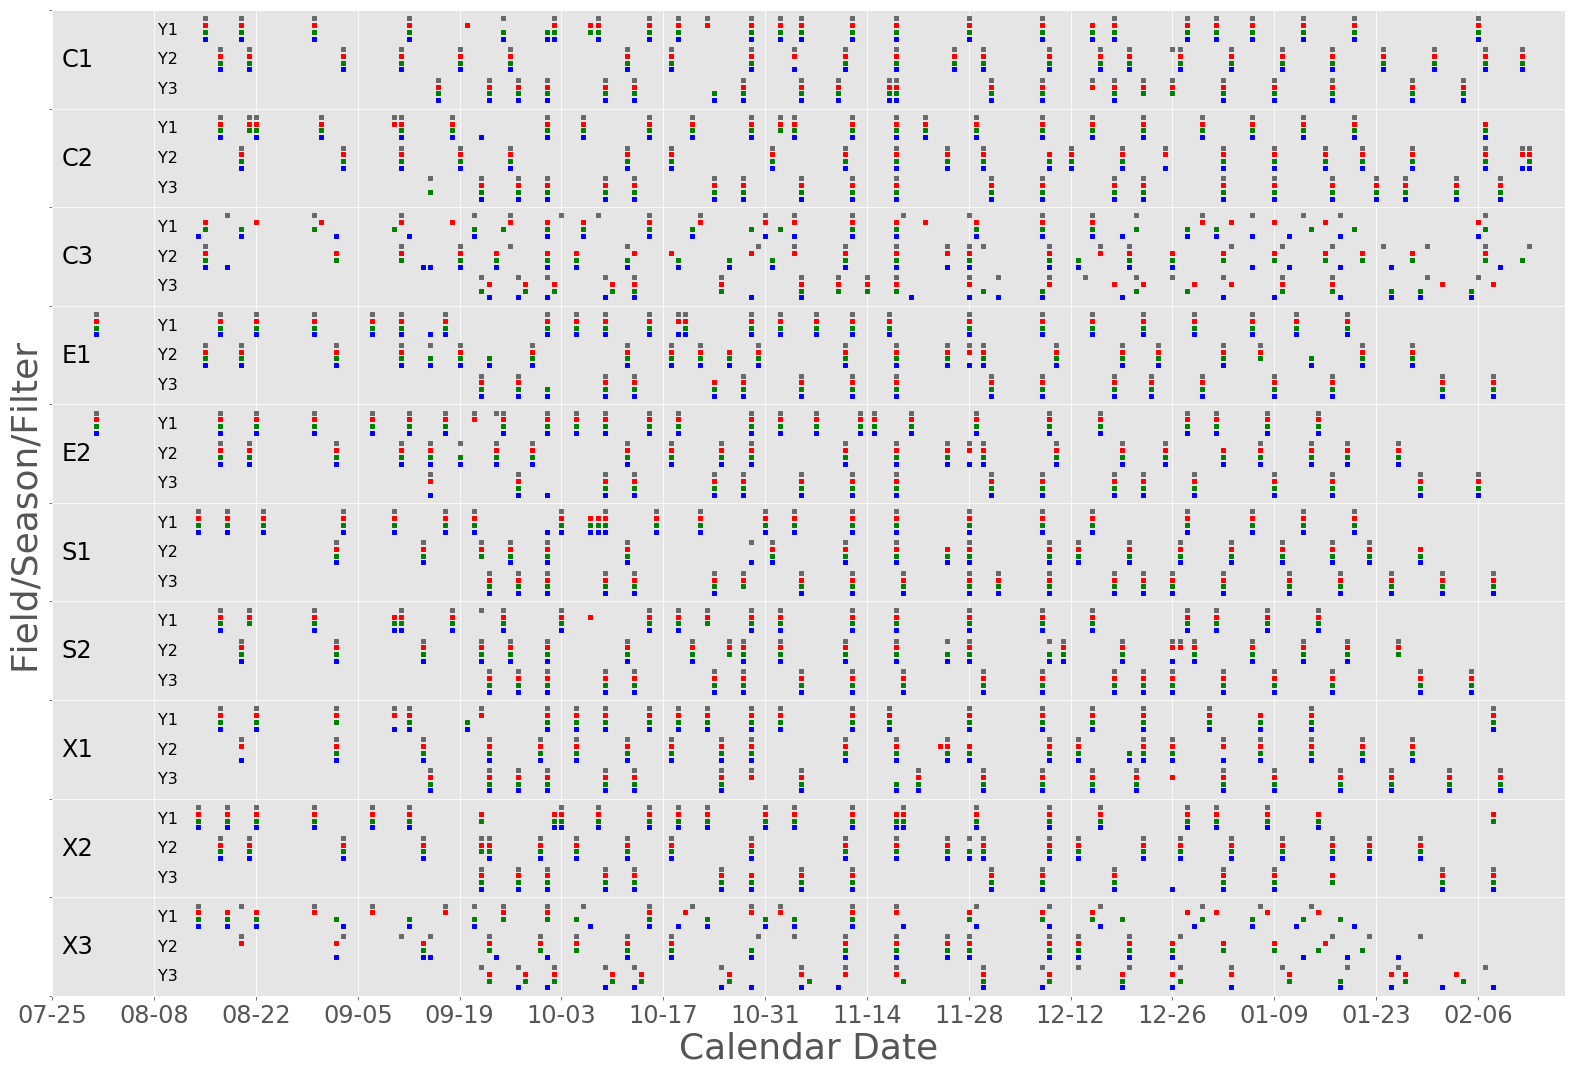

In [88]:
#PLOT FOR PAPER:  Histogram of Depth by field
f, ax = plt.subplots(1,1, figsize=(22,15))
mpl.style.use('ggplot')
ax.grid(True)

color1  = ['blue', 'green', 'red', 'dimgrey']
color2  = ['dodgerblue', 'lightgreen', 'lightsalmon', 'darkgrey']
Band = ['g', 'r', 'i', 'z']
Field = ['C1','C2','C3','E1','E2','S1','S2','X1','X2','X3']
Year  = ['Y1','Y2','Y3']

for i,bx in enumerate(Field):
    #ax.text(0.02,40-2*i,bx,fontsize=20,ha='left',va='center',transform = ax.transAxes)

    for j, by in enumerate(Year):
        for k, bz in enumerate(Band):
            
            mjd_low  = Time(str(2013+j)+'-06-06', format='isot', scale='utc').mjd
            mjd_high = Time(str(2014+j)+'-06-06', format='isot', scale='utc').mjd

            query = "BAND == '{0}' and FIELD == 'SN-'+'{1}' and MJD > {2} and MJD < {3}"
            g = qual.query(query.format(bz,bx,mjd_low,mjd_high))

            #print ax,ay,az,len(g)
        
            x = g['MJD'].sort_values(ascending=True)
            x -= j*365
            
            ax.plot(x,np.ones_like(x)*(40 - (i+1)*4 + 0.2 + j*1.25 + 0.1375 + k*0.275),
                    color=color1[k],marker='s',markersize=4.5,linestyle='none')
            


ax.tick_params(axis='both', which='major', labelsize=24)

ax.set_ylabel('Field/Season/Filter',fontsize=36)
ax.set_xlabel('Calendar Date',fontsize=36)

ax.set_ylim(0,40)
ax.set_xlim(mjd0,mjd1)

ax.yaxis.set_major_locator(MultipleLocator(4))
#ax.yaxis.set_minor_locator(MultipleLocator(7))

ax.set_xticks(mjd_arr)
ax.set_yticklabels([])
ax.set_xticklabels(nite_arr)

#ax.lines.linewidth(2)

for i,bx in enumerate(Field):
    ax.text(0.006,0.95-0.1*i,bx,fontsize=24,ha='left',va='center',transform = ax.transAxes)

    ax.text(0.070,0.95-0.1*i-0.03,'Y3',fontsize=16,ha='left',va='center',transform = ax.transAxes)
    ax.text(0.070,0.95-0.1*i-0.00,'Y2',fontsize=16,ha='left',va='center',transform = ax.transAxes)
    ax.text(0.070,0.95-0.1*i+0.03,'Y1',fontsize=16,ha='left',va='center',transform = ax.transAxes)
    
f.savefig('DES-CadenceFullChart.pdf', format='pdf', bbox_inches='tight')
#plt.close()
#ax.set_facecolor('white')
#ax.set_axis_bgcolor('k')

plt.tight_layout()
plt.show()
plt.close()